In [207]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import re

In [208]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100000)
pd.set_option('display.max_colwidth', None)  

In [209]:
data = pd.read_csv("raw_llama70b_full_part1.csv")
data1 = pd.read_csv("raw_llama70b_full_part2.csv")
data2 = pd.read_csv("raw_llama70b_full_part3.csv")

In [210]:
# TRAIN_PATH = "train_llama3-70b_regenerated_detailed.csv"
TRAIN_PATH = "LIE_dataset.csv"
train_df = pd.read_csv(TRAIN_PATH)
train_df.shape

(1000, 28)

In [211]:
cols_to_drop = ['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore', 'Q_RelevantIDDuplicate', 'Q_RelevantIDDuplicateScore',
        'Q_RelevantIDFraudScore',
         'Q_RelevantIDLastStartDate',
         '44_1',
         '47_1',
         '26_1',
         '53_1',
         '37_1',
         'Q60',
         'participantId',
         'assignmentId',
         'projectId',
         'incorrect1',
         'incorrect2',
         'incorrect3',
         'incorrect4',
         'incorrect5',
         'incorrect',
         'Create New Field or Choose From Dropdown...']

In [212]:
updated_data_df1 = data1.drop(cols_to_drop, axis=1)
updated_data_df2 = data2.drop(cols_to_drop, axis=1)
cols_to_drop.remove('Create New Field or Choose From Dropdown...')
updated_data_df = data.drop(cols_to_drop, axis=1)

In [213]:
updated_data_df = pd.concat([updated_data_df, updated_data_df1, updated_data_df2]) 

In [214]:
decision_time = {}
num_clicks = {}
scratch_space = {}
for i in range(0, updated_data_df.shape[1], 6):
    question_col = updated_data_df.columns[i]
    assert "First Click" in updated_data_df.columns.values[i + 1]
    assert "Last Click" in updated_data_df.columns.values[i + 2]
    assert "Click Count" in updated_data_df.columns.values[i + 4]
    assert "scratch" in updated_data_df.columns.values[i + 5]
    
    first_click = updated_data_df[updated_data_df.columns.values[i + 1]].drop([0,1]).fillna(0).astype(float).sum()
    last_click = updated_data_df[updated_data_df.columns.values[i + 2]].drop([0,1]).fillna(0).astype(float).sum()
    decision_time[question_col] = last_click-first_click
    num_clicks[question_col] = updated_data_df[updated_data_df.columns.values[i + 4]].drop([0,1]).fillna(0).astype(float).sum()
    question_col_series = updated_data_df[updated_data_df.columns.values[i + 5]].drop([0,1])
    first_valid_index = question_col_series.dropna().first_valid_index()
    non_null_string = question_col_series[first_valid_index].values[0] if first_valid_index is not None else None
    scratch_space[question_col] = non_null_string

In [215]:
updated_data_df = updated_data_df.loc[:, ~updated_data_df.columns.str.contains('Click')]
updated_data_df = updated_data_df.loc[:, ~updated_data_df.columns.str.contains('Submit')]
updated_data_df = updated_data_df.loc[:, ~updated_data_df.columns.str.contains('scratch')]

In [216]:
updated_data_df_id_to_train_id = {}
index_to_combined_row = {}

def parse_input(text, df):
    user_pattern = r"User: (.*?)\n\nResponse A:"
    response_a_pattern = r"Response A: (.*?)\nResponse B:"
    response_b_pattern = r"Response B: (.*)\n\nChoose"

    user = re.search(user_pattern, text, re.S)
    response_a = re.search(response_a_pattern, text, re.S)
    response_b = re.search(response_b_pattern, text, re.S)

    user_text = user.group(1).strip() if user else None
    response_a_text = response_a.group(1).strip() if response_a else None
    response_b_text = response_b.group(1).strip() if response_b else None
    return user_text, response_a_text, response_b_text

def parse_input_to_row(text, df):
    user_pattern = r"User: (.*?)\n\nResponse A:"
    response_a_pattern = r"Response A: (.*?)\nResponse B:"
    response_b_pattern = r"Response B: (.*)\n\nChoose"

    user = re.search(user_pattern, text, re.S)
    response_a = re.search(response_a_pattern, text, re.S)
    response_b = re.search(response_b_pattern, text, re.S)

    user_text = user.group(1).strip() if user else None
    response_a_text = response_a.group(1).strip() if response_a else None
    response_b_text = response_b.group(1).strip() if response_b else None

    row = df[(df["questions"] == user_text) & (df["choice1"] == response_a_text) & (df["choice2"] == response_b_text)]

    return row

failures = []
for col in updated_data_df.columns:
    try:
        ID = col.split("_")[0]
        row = train_df[train_df["tag_IDs"]==int(ID)]
        updated_data_df_id_to_train_id[col] = row.index[0]
        index_to_combined_row[row.index[0]] = col
    except:
        failures.append(col)

In [217]:
updated_data_df = updated_data_df.drop([0, 1])
updated_data_df = updated_data_df.reset_index(drop=True)
updated_data_df = updated_data_df.fillna(0)
updated_data_df = updated_data_df.astype(int)

In [218]:
non_zero_counts = updated_data_df.apply(np.count_nonzero)
columns_with_only_zeros = non_zero_counts[non_zero_counts < 1].index.tolist()
print(columns_with_only_zeros)
updated_data_df = updated_data_df.drop(columns_with_only_zeros, axis=1)

[]


In [219]:
non_zero_counts = updated_data_df.apply(np.count_nonzero)
columns_with_more_than_one_non_zero = non_zero_counts[non_zero_counts > 1].index.tolist()
print(len(columns_with_more_than_one_non_zero))

0


In [220]:
non_zero_counts_per_row = updated_data_df.apply(np.count_nonzero, axis=1)
filtered_rows = updated_data_df.loc[non_zero_counts_per_row > 50]
filtered_rows.shape

(0, 1000)

In [221]:
combined_row = updated_data_df.agg(['sum'])
combined_row = combined_row.reset_index(drop=True)

In [222]:
combined_row.shape

(1, 1000)

In [223]:
tags = [tag[0:4] for tag in list(combined_row.columns)]

In [224]:
# key_mapping = {
#     "1112": "A: Correct, concise. B: Correct, detailed.",
#     "1121": "A: Correct, concise. B: Incorrect, concise.",
#     "1122": "A: Correct, concise. B: Incorrect, detailed.",
#     "1221": "A: Correct, detailed. B: Incorrect, concise.",
#     "1222": "A: Correct, detailed. B: Incorrect, detailed.",
#     "2122": "A: Incorrect, concise. B: Incorrect, detailed.",
#     "1211": "A: Correct, detailed. B: Correct, concise.",
#     "2111": "A: Incorrect, concise. B: Correct, concise.",
#     "2211": "A: Incorrect, detailed. B: Correct, concise.",
#     "2112": "A: Incorrect, concise. B: Correct, detailed.",
#     "2212": "A: Incorrect, detailed. B: Correct, detailed.",
#     "2221": "A: Incorrect, detailed. B: Incorrect, concise."
# }

key_mapping = {
    "1112": "A: ✓, Short. B: ✓, Long.",
    "1121": "A: ✓, Short. B: ✗, Short.",
    "1122": "A: ✓, Short. B: ✗, Long.",
    "1221": "A: ✓, Long. B: ✗, Short.",
    "1222": "A: ✓, Long. B: ✗, Long.",
    "2122": "A: ✗, Short. B: ✗, Long.",
    "1211": "A: ✓, Long. B: ✓, Short.",
    "2111": "A: ✗, Short. B: ✓, Short.",
    "2211": "A: ✗, Long. B: ✓, Short.",
    "2112": "A: ✗, Short. B: ✓, Long.",
    "2212": "A: ✗, Long. B: ✓, Long.",
    "2221": "A: ✗, Long. B: ✗, Short."
}

Per-category likelihoods of correctness and average confidences

In [225]:
def combine_reversed_entries(data):
    combined_data = {}
    already_combined = set()

    for key1 in data:
        if key1 in already_combined:
            continue  
        
        reversed_key = key1[2:] + key1[:2]
        
        if reversed_key in data and reversed_key not in already_combined:
            combined_count = data[key1] + data[reversed_key]
            combined_data[key1] = combined_count  
            
            already_combined.add(key1)
            already_combined.add(reversed_key)
        else:
            combined_data[key1] = data[key1]

    return combined_data

In [226]:
# the preferred choice is either the correct one or the detailed one if factually correct
def get_preferred_choice(tag):
    if tag[0] == '1' and tag[2] == "2":
        preferred_choice = 'A'
    elif tag[2] == '1' and tag[0] == "2":
        preferred_choice = 'B'
    elif tag[1] == '2':  
        preferred_choice = 'A'
    else:  
        preferred_choice = 'B'

    return preferred_choice

In [231]:
def per_question_likelihood(column_name, df):
    tag = column_name[0:4]
    preferred_choice = get_preferred_choice(tag)
    
    score = df[column_name].iloc[0]
    
    if (preferred_choice == 'A' and 1 <= score <= 4) or (preferred_choice == 'B' and 5 <= score <= 8):
        preferred_count = 1
    else:
        preferred_count = 0

    return preferred_count

def calculate_likelihoods(df):
    total_counts = {}
    correctness_counts = {}
    for column_name in df.columns:
        tag = column_name[0:4]
        preferred_choice = get_preferred_choice(tag)
        
        scores = df[column_name].tolist()
        total_counts[tag] = total_counts.get(tag, 0) + len(scores)

        preferred_count = 0
        for score in scores:
            if (preferred_choice == 'A' and 1 <= score <= 4) or (preferred_choice == 'B' and 5 <= score <= 8):
                preferred_count += 1

        correctness_counts[tag] = correctness_counts.get(tag, 0) + preferred_count

    correctness_counts = combine_reversed_entries(correctness_counts)
    total_counts = combine_reversed_entries(total_counts)
    
    likelihood_results = {tag: (correctness_counts[tag] / total_counts[tag]) * 100 for tag in total_counts}
    likelihood_confints = {}
    for tag in total_counts:
        likelihood_confints[tag] = proportion_confint(
            correctness_counts[tag],
            total_counts[tag],
            alpha=0.1,
        )
    
    return likelihood_results, likelihood_confints, correctness_counts, total_counts

In [232]:
def normalize_confidence_scores(score):
    if score <= 4:
        return (4 - score) / 3  
    else:
        return (score - 5) / 3  

def calculate_ci(scores, confidence=1.645):
    mean_score = np.mean(scores)
    std_dev = np.std(scores, ddof=1)  
    n = len(scores)
    sem = std_dev / np.sqrt(n)  
    margin_error = sem * confidence
    
    lower_bound = mean_score - margin_error
    upper_bound = mean_score + margin_error
    
    return (lower_bound, upper_bound)

def calculate_normalized_average_confidence(df):
    total_normalized_scores = {}
    normalized_scores_by_tag = {}
    response_counts = {}

    for column_name in df:
        tag = column_name[0:4]
        scores = df[column_name].tolist()
        response_counts[tag] = response_counts.get(tag, 0) + len(scores)

        for score in scores:
            normalized_score = normalize_confidence_scores(score)
            total_normalized_scores[tag] = total_normalized_scores.get(tag, 0) + normalized_score
            normalized_scores_by_tag.setdefault(tag, []).append(normalized_score)
    
    total_normalized_scores = combine_reversed_entries(total_normalized_scores)
    normalized_scores_by_tag = combine_reversed_entries(normalized_scores_by_tag)
    response_counts = combine_reversed_entries(response_counts)

    average_normalized_scores = {}
    confidence_int = {}
    for tag, total_score in total_normalized_scores.items():
        average_score = total_score / response_counts[tag] if response_counts[tag] > 0 else 0
        average_normalized_scores[tag] = average_score
        ci = calculate_ci(normalized_scores_by_tag[tag], 1.645)  
        confidence_int[tag] = ci
        
    return average_normalized_scores, confidence_int

In [239]:
likelihoods_unmapped, likelihood_confints, correctness_counts, counts_per_category = calculate_likelihoods(combined_row)
likelihoods = {key_mapping[old_key]: value for old_key, value in likelihoods_unmapped.items()}
likelihood_confints = {key_mapping[old_key]: value for old_key, value in likelihood_confints.items()}
counts_per_category = {key_mapping[old_key]: value for old_key, value in counts_per_category.items()}
correctness_counts = {key_mapping[old_key]: value for old_key, value in correctness_counts.items()}

In [240]:
average_confidences_unmapped, confidence_int = calculate_normalized_average_confidence(combined_row)
average_confidences = {key_mapping[old_key]: value for old_key, value in average_confidences_unmapped.items()}
confidence_int = {key_mapping[old_key]: value for old_key, value in confidence_int.items()}

<Figure size 1000x600 with 0 Axes>

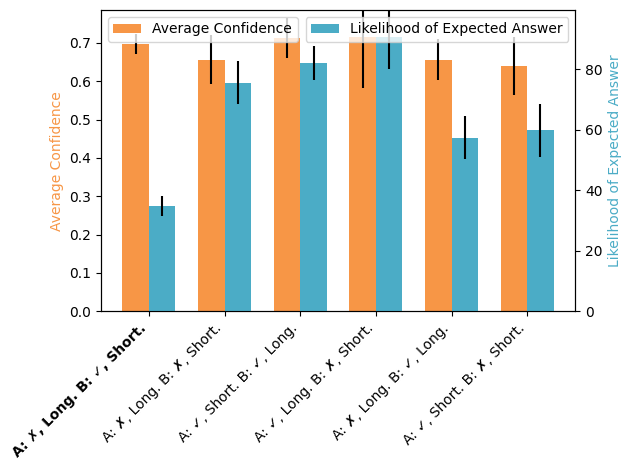

In [241]:
labels = average_confidences.keys()
avg_conf_values = np.array([average_confidences[label] for label in labels])
avg_confint_arr = np.array([confidence_int[label] for label in labels]).transpose()
avg_confint_arr = np.abs(avg_confint_arr - avg_conf_values[None, :])

likelihood_values = np.array([likelihoods[label] for label in labels])
likelihood_confint_arr = np.array([likelihood_confints[label] for label in labels]).transpose()
likelihood_confint_arr = np.abs(likelihood_confint_arr * 100 - likelihood_values[None, :])

x = np.arange(len(labels))
width = 0.35 

plt.figure(figsize=(10, 6))

fig, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, avg_conf_values, width, yerr=avg_confint_arr, label='Average Confidence', color='#F79646')

ax2 = ax1.twinx() 
rects2 = ax2.bar(x + width/2, likelihood_values, width, yerr=likelihood_confint_arr, label='Likelihood of Expected Answer', color='#4BACC6')

ax1.set_ylabel('Average Confidence', color='#F79646')
ax2.set_ylabel('Likelihood of Expected Answer', color='#4BACC6')
# ax1.set_title('Concise vs. Detailed Study')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=10) 

for i, label in enumerate(ax1.get_xticklabels()):
    if i == 0: 
        label.set_fontweight('bold')

ax1.set_ylim(0, max(avg_conf_values) * 1.1)
ax2.set_ylim(0, max(likelihood_values) * 1.1)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# plt.savefig("avg_conf_and_likelihood.png")
plt.tight_layout()

plt.savefig("avg_conf_and_likelihood.pdf", format='pdf')

plt.show()

In [242]:
counts_per_category

{'A: ✗, Long. B: ✓, Short.': 542,
 'A: ✗, Long. B: ✗, Short.': 98,
 'A: ✓, Short. B: ✓, Long.': 123,
 'A: ✓, Long. B: ✗, Short.': 21,
 'A: ✗, Long. B: ✓, Long.': 129,
 'A: ✓, Short. B: ✗, Short.': 87}

In [243]:
correctness_counts

{'A: ✗, Long. B: ✓, Short.': 188,
 'A: ✗, Long. B: ✗, Short.': 74,
 'A: ✓, Short. B: ✓, Long.': 101,
 'A: ✓, Long. B: ✗, Short.': 19,
 'A: ✗, Long. B: ✓, Long.': 74,
 'A: ✓, Short. B: ✗, Short.': 52}

<Figure size 1000x600 with 0 Axes>

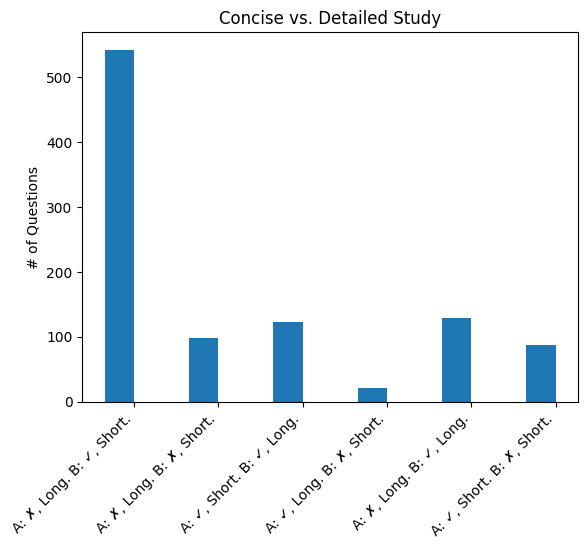

In [183]:
labels = counts_per_category.keys()
x = np.arange(len(labels))
width = 0.35 

total_category_count_values = np.array([counts_per_category[label] for label in labels])

plt.figure(figsize=(10, 6))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_category_count_values, width)

ax.set_ylabel('# of Questions')
ax.set_title('Concise vs. Detailed Study')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10) 

plt.savefig("total_counts_per_category.png")
plt.show()

In [184]:
likelihoods

{'A: ✗, Long. B: ✓, Short.': 34.686346863468636,
 'A: ✗, Long. B: ✗, Short.': 75.51020408163265,
 'A: ✓, Short. B: ✓, Long.': 82.11382113821138,
 'A: ✓, Long. B: ✗, Short.': 90.47619047619048,
 'A: ✗, Long. B: ✓, Long.': 57.36434108527132,
 'A: ✓, Short. B: ✗, Short.': 59.77011494252874}

Assign chosen and rejected values for train set

In [185]:
train_df.shape

(1000, 15)

In [186]:
chosen = [None]*train_df.shape[0]
rejected = [None]*train_df.shape[0]
chosen_type = [None]*train_df.shape[0]
rejected_type = [None]*train_df.shape[0]
conf_scores = [None]*train_df.shape[0]
conf_difficulty = [None]*train_df.shape[0]
decision_times = [None]*train_df.shape[0]
number_of_clicks = [None]*train_df.shape[0]
scratch_space_lst = [None]*train_df.shape[0]

train_df["chosen"] = chosen
train_df["rejected"] = rejected
train_df["chosen_type"] = chosen_type
train_df["rejected_type"] = rejected_type
train_df["confidence_scores"] = conf_scores
train_df["confidence_difficulty"] = conf_difficulty
train_df["decision_time"] = decision_times
train_df["number_of_clicks"] = number_of_clicks
train_df["scratch_space"] = scratch_space_lst

for index, col in index_to_combined_row.items():
    row = train_df.iloc[index]
    score = combined_row[col][0]
    train_df.loc[index, "confidence_scores"] = normalize_confidence_scores(score)
    train_df.loc[index, "confidence_difficulty"] = 1-normalize_confidence_scores(score)
    train_df.loc[index, "raw_number_of_clicks"] = num_clicks[col]
    train_df.loc[index, "raw_decision_time"] = decision_time[col]
    train_df.loc[index, "scratch_space"] = scratch_space[col]
    train_df.loc[index, "prompt_response_group"] = f"Prompt: {row['prompt']}\n\nResponse A: {row['choice1']}\n\nResponse B: {row['choice2']}"

    if score <= 4:
        train_df.loc[index, "chosen"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice1']}"
        train_df.loc[index, "rejected"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice2']}"
        train_df.loc[index, "chosen_type"] = row["choice1_type"]
        train_df.loc[index, "rejected_type"] = row["choice2_type"]
    else:
        train_df.loc[index, "chosen"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice2']}"
        train_df.loc[index, "rejected"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice1']}"
        train_df.loc[index, "chosen_type"] = row["choice2_type"]
        train_df.loc[index, "rejected_type"] = row["choice1_type"]
    

In [187]:
# train_df["log_decision_time"] = train_df["raw_decision_time"].apply(lambda x: np.log1p(max(x, 0)))

In [188]:
train_df['decision_time'] = (train_df['raw_decision_time'] - train_df['raw_decision_time'].min()) / (train_df['raw_decision_time'].max() - train_df['raw_decision_time'].min())
train_df['number_of_clicks'] = (train_df['raw_number_of_clicks'] - train_df['raw_number_of_clicks'].min()) / (train_df['raw_number_of_clicks'].max() - train_df['raw_number_of_clicks'].min())

In [190]:
# train_df['log_norm_decision_time'] = (train_df['log_decision_time'] - train_df['log_decision_time'].min()) / (train_df['log_decision_time'].max() - train_df['log_decision_time'].min())

In [189]:
# train_df["decision_time_beta"] = 1-train_df['decision_time']
# train_df["num_clicks_beta"] = 1-train_df["number_of_clicks"]

In [191]:
# train_df["confidence_beta"] = 1 - train_df["confidence_difficulty"]

In [203]:
train_df.to_csv(TRAIN_PATH, index=False)

In [192]:
train_df["number_of_clicks"].dropna().shape

(1000,)

In [200]:
train_df.columns

Index(['categories', 'correct_concise', 'incorrect_concise', 'correct_detailed', 'choice1_type', 'choice2_type', 'correct_statements', 'incorrect_statements', 'incorrect_detailed', 'IDs', 'tags', 'tag_IDs', 'choice1', 'choice2', 'prompt', 'chosen', 'rejected', 'chosen_type', 'rejected_type', 'confidence_scores', 'confidence_difficulty', 'decision_time', 'number_of_clicks', 'scratch_space', 'raw_number_of_clicks', 'raw_decision_time', 'prompt_response_group'], dtype='object')

In [201]:
train_df.shape

(1000, 27)

In [202]:
TRAIN_PATH

'LIE_dataset.csv'